In [1]:
%matplotlib inline

In [2]:
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
import tensorflow as tf
import numpy as np
from tensorflow.contrib import signal

In [8]:
import os
import sys
import re

In [70]:
import config as cfg
from dataload import load_test_batch, load_data, load_batch, load_config
from preprocessing import signalProcessBatch, tf_diff_axis
from models import buildModel

In [18]:
# Tensorflow setup
sess = None
tf.logging.set_verbosity(tf.logging.INFO)

def reset_vars():
    """Initializes all tf variables"""
    sess.run(tf.global_variables_initializer())

def reset_tf():
    """Closes the current tf session and opens new session"""
    global sess
    if sess:
        sess.close()
    tf.reset_default_graph()
    sess = tf.Session()

## Load some test files

In [25]:
reset_tf()

In [26]:
X_data_values, X_filenames = load_test_batch(cfg.DATA_DIR, idx=10, batch_size=2, samples=cfg.SAMRATE)

In [27]:
X_data = tf.placeholder(tf.float32, [None, cfg.SAMRATE], name='X_data')

In [28]:
x_mfcc, x_mel, x_zcr, x_rmse = signalProcessBatch(X_data,
                                                  noise_factor=0.0,
                                                  noise_frac=0.0,
                                                  window=512,
                                                  maxamps=cfg.MAXAMPS, sr=cfg.SAMRATE,
                                                  num_mel_bins=64,
                                                  num_mfccs=20)

In [29]:
x_mfcc_val, x_mel_val, x_zcr_val, x_rmse_val = sess.run(
    [x_mfcc, x_mel, x_zcr, x_rmse],
    feed_dict={X_data: X_data_values})

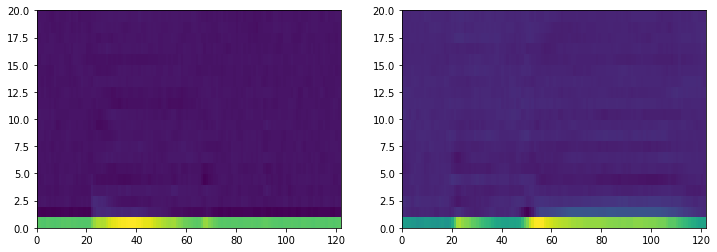

In [68]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.pcolormesh(x_mfcc_val[0].T)
plt.subplot(122)
plt.pcolormesh(x_mfcc_val[1].T);

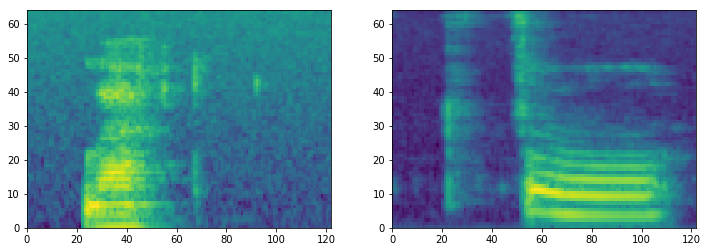

In [69]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.pcolormesh(x_mel_val[0].T)
plt.subplot(122)
plt.pcolormesh(x_mel_val[1].T);

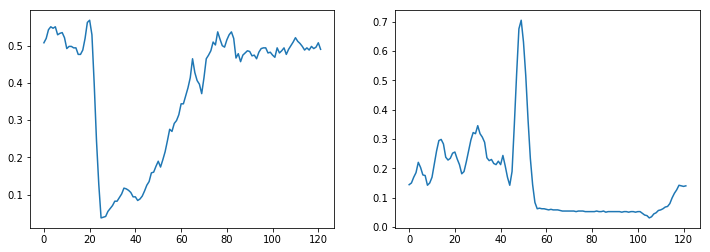

In [71]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(x_zcr_val[0])
plt.subplot(122)
plt.plot(x_zcr_val[1]);

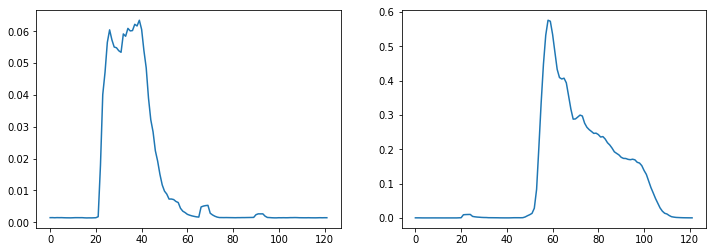

In [73]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(x_rmse_val[0])
plt.subplot(122)
plt.plot(x_rmse_val[1]);

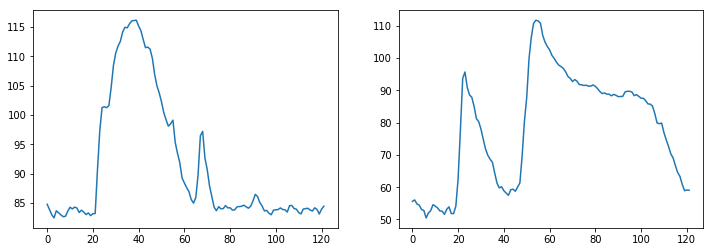

In [72]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(x_mfcc_val[0].T[0])
plt.subplot(122)
plt.plot(x_mfcc_val[1].T[0]);

In [102]:
# Deltas
paddings = tf.constant([[0, 0], [0, 1]])
zcr_delta = sess.run(tf.pad(tf_diff_axis(x_zcr_val), paddings, 'CONSTANT'))
rmse_delta = sess.run(tf.pad(tf_diff_axis(x_rmse_val), paddings, 'CONSTANT'))

In [103]:
print zcr_delta.shape
print x_zcr_val.shape

(2, 122)
(2, 122)


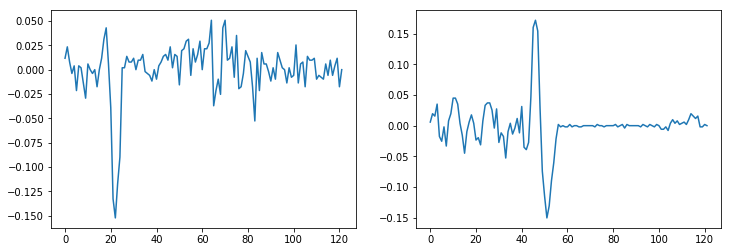

In [104]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(zcr_delta[0])
plt.subplot(122)
plt.plot(zcr_delta[1]);

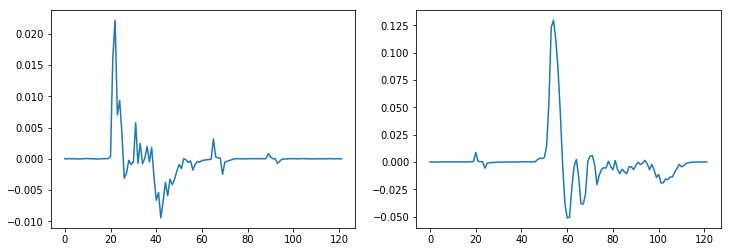

In [105]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(rmse_delta[0])
plt.subplot(122)
plt.plot(rmse_delta[1]);

In [147]:
# Reshape to [audio file number, time size, 1]
x_zcr_val_rs = tf.reshape(x_zcr_val, [-1, 122, 1])
zcr_delta_rs = tf.reshape(zcr_delta, [-1, 122, 1])
x_rmse_val_rs = tf.reshape(x_rmse_val, [-1, 122, 1])
rmse_delta_rs = tf.reshape(rmse_delta, [-1, 122, 1])

# Stack together zcr and rmse features using tf.concat
zr_stack = tf.concat([x_zcr_val_rs, zcr_delta_rs, x_rmse_val_rs, rmse_delta_rs], 2)

# Stack with the mfccs using tf.concat
fingerprint = tf.concat([zr_stack, x_mfcc_val], 2)

In [155]:
# Normalize
fingerprint_norm = sess.run(tf.nn.l2_normalize(fingerprint, 1, epsilon=1e-8))

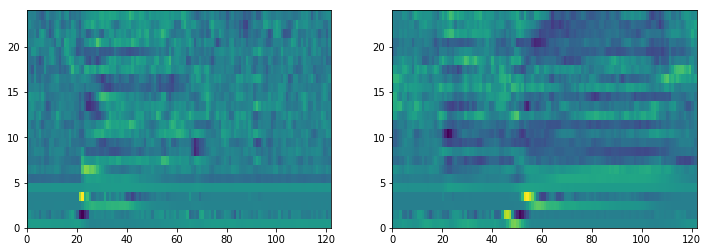

In [156]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.pcolormesh(fingerprint_norm[0].T)
plt.subplot(122)
plt.pcolormesh(fingerprint_norm[1].T);